Code used for creating the pictures in the Master's thesis

In [1]:
import numpy as np

import torch

import matplotlib.pyplot as plt

from tqdm import tqdm
from ray_transforms import get_ray_trafo, get_static_ray_trafo
from test_model_functions_swaped import get_net_corected_operator
# import random
import torch 


import os
from conf import config
from select_model_type_matrix import select_fwd_model_type,select_adj_model_type
from scipy import sparse
from util import get_op,Mat,plots,rand_shift_params,error_for_y,check_path,hide_axis

def im_norm(x):
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)

def sp(a,b):
    return a.reshape(a.size)@b.reshape(b.size)

def ISTA_obj_func(op,y,lam,x):
    return 1/(2*lam)*np.linalg.norm((op(x)-y).reshape(y.size),2)**2+np.linalg.norm(x.reshape(x.size),1)

def Test_PGM(step_op,L,grad_R,true_op,p,y_e,x_0_selector,test_op,mu,lam,num_iter):
    F_abl = lambda x: test_op.adjoint(test_op(x)-y_e)/lam + grad_R(x)
    F_true_abl = lambda x: true_op.adjoint(true_op(x)-y_e)/lam + grad_R(x)
    x = x_0_selector(y_e)
    X = np.zeros((num_iter + 1,x.shape[0],x.shape[1]))
    X[0] = x
    loss = np.zeros(num_iter+1)
    loss[0] = im_norm(p-x)
    TThetaMu = np.zeros(num_iter)
    LL = np.zeros(num_iter)
    AL = np.zeros(num_iter)
    FwL = np.zeros(num_iter)
    AdL = np.zeros(num_iter)
    FF = np.zeros(num_iter)
    for i in range(num_iter):
        x_old = x
        x = step_op(x,F_abl(x))
        X[i+1] = x
        loss[i+1] = im_norm(p-x)
        T_Thetamu = (x_old-x)/(mu)
        TThetaMu[i] = im_norm(T_Thetamu)
        LL[i] = L(x_old)-L(x)
        AL[i] = mu*(0.5*TThetaMu[i]**2+sp(F_true_abl(x_old)-F_abl(x_old),T_Thetamu))
        FwL[i] = im_norm(true_op(x)-test_op(x))
        r = test_op(x)-y_e
        AdL[i] = im_norm(true_op.adjoint(r)-test_op.adjoint(r))
        FF[i] = im_norm(F_true_abl(x_old)-F_abl(x_old))
    X = X[np.arange(9,num_iter,10)]
    return {'X':X,'loss':loss,'TThetaMu':TThetaMu,'LL':LL,'AL':AL,'FwL':FwL,'AdL':AdL}

def Test_GD(step_op,L,grad_R,true_op,p,y_e,x_0_selector,test_op,mu,num_iter):
    """_summary_

    Args:
        step_op (_type_): an operator that produces the next iteration x_k+1 = step_op(x_k,F(x_k))
        L (_type_): The objective function that is minimized for testing only
        grad_R (_type_): the differentialle part of the regularization terms
        true_op (_type_): the precise operator we try to achieve
        p (_type_): the phantom
        y_e (_type_): noisy data
        x_0_selector (_type_): function that gives the x_0 deppending on y_e
        test_op (_type_): the operaator we want to test
        adj_test_op (_type_): the adjoint of the test opeartor
        mu (_type_): constant step size for 
        num_iter (_type_): number of iterations taht are being computed

    Returns:
        _type_: _description_
    """ 
    F_abl = lambda x: test_op.adjoint(test_op(x)-y_e) + grad_R(x)
    F_true_abl = lambda x: true_op.adjoint(true_op(x)-y_e) + grad_R(x)
    x = x_0_selector(y_e)
    X = np.zeros((num_iter + 1,x.shape[0],x.shape[1]))
    X[0] = x
    loss = np.zeros(num_iter+1)
    loss[0] = im_norm(p-x)
    TMu = np.zeros(num_iter)
    LL = np.zeros(num_iter)
    AL = np.zeros(num_iter)
    FF = np.zeros(num_iter)
    FwL = np.zeros(num_iter)
    AdL = np.zeros(num_iter)
    for i in range(num_iter):
        x_old = x
        x = step_op(x,F_abl(x))
        X[i+1] = x
        loss[i+1] = im_norm(p-x)
        grad_F = F_true_abl(x_old)
        TMu[i] = im_norm(grad_F)
        LL[i] = L(x_old)-L(x)
        AL[i] = mu*(sp(grad_F,F_abl(x_old))/TMu[i]**2)
        FF[i] = im_norm(F_true_abl(x_old)-F_abl(x_old))
        FwL[i] = im_norm(true_op(x)-test_op(x))
        r = test_op(x)-y_e
        AdL[i] = im_norm(true_op.adjoint(r)-test_op.adjoint(r))
    X = X[np.arange(9,num_iter,10)]
    return {'X':X,'loss':loss,'TMu':TMu,'LL':LL,'AL':AL,'FF':FF,'FwL':FwL,'AdL':AdL}


class net_cor_op():
    def __init__(self,static_op,fw_model,fw_swaped,adjoint_model,adj_swaped,device) -> None:
        """creates a operator 

        Args:
            static_op (_type_): _description_
            fw_model (_type_): _description_
            fw_swaped (_type_): _description_
            adjoint_model (_type_): _description_
            adj_swaped (_type_): _description_
            device (_type_): _description_
        """
        self.cor_op = get_net_corected_operator(static_op, fw_model,device = device,swaped=fw_swaped)
        self.cor_adj_op = get_net_corected_operator(static_op.adjoint, adjoint_model,device = device,swaped=adj_swaped)
    def __call__(self, x) -> np.array:
        """returns the forward operator

        Args:
            x (_type_): _description_

        Returns:
            np.array: _description_
        """
        return self.cor_op(x)
    def adjoint(self, x) -> np.array:
        """returns the adjoint of the opearator

        Args:
            x (_type_): _description_

        Returns:
            np.array: _description_
        """
        return self.cor_adj_op(x)

def soft_shrink(x,alpha):
    """the soft shrinkige operator
    Args:
        x (np.array): input
        alpha ( float ): parameter

    Returns:
        np.array: soft_schrink(x)
    """
    return np.sign(x) * np.maximum(np.abs(x)-alpha,0)
    


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
gpu_idx = 0
device = f"cuda:{gpu_idx}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import astra
astra.set_gpu_index(gpu_idx)

Using cuda:0 device


In [4]:
A_static_s = sparse.load_npz('Matritzen/64_64_256_96_static.npz')
x_res = 64
y_res = 64
num_angles = 256
detector_points = 96
static_op = get_op(A_static_s,x_res, y_res, num_angles, detector_points)
static_ray_trafo = get_static_ray_trafo(x_res, y_res,num_angles,detector_points,detector_len=2)

In [5]:
tp = np.load(file='phantoms/test_phantoms_64_1.npy')
tpval = np.load(file='phantoms/validation_phantoms_64_10.npy')
p = tp[0,:,:]
p.shape

(64, 64)

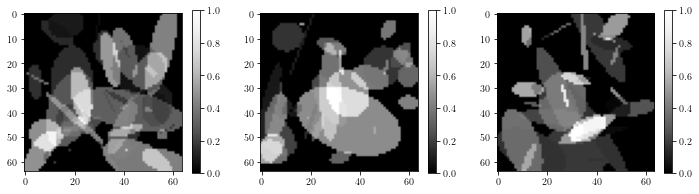

In [6]:
fig,axs = plots(1,3,4/3)
im = axs[0].imshow(p,cmap = 'Greys_r')
fig.colorbar(im,ax = axs[0])
im = axs[1].imshow(tpval[5],cmap = 'Greys_r')
fig.colorbar(im,ax = axs[1])
im = axs[2].imshow(tpval[7],cmap = 'Greys_r')
fig.colorbar(im,ax = axs[2])
#fig.set_dpi(200)

In [7]:
def x_0is0(y):
    return np.zeros((x_res,y_res))
def x_0isATy(y):
    return static_op.adjoint(y)
def x_0isp(y):
    return p

In [8]:
import odl
R = odl.solvers.Huber(static_ray_trafo.domain,0.001)
grad_R = lambda x :R.gradient(x).asarray()

In [16]:
runs_list = []
operator_list = []
op_name_list = []
i = 10
# A_u = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/u_ray_trafo_{i}.npz")
# u_op = get_op(A_u,x_res, y_res, num_angles, detector_points)
# operator_list.append(u_op)
# op_name_list.append(r'$n=1$, $u$ shift')
# A_v = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/v_ray_trafo_{i}.npz")
# v_op = get_op(A_v,x_res, y_res, num_angles, detector_points)
# operator_list.append(v_op)
# op_name_list.append(r'$n=1$, $v$ shift')
A_u_v = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_{i}.npz")
u_v_op = get_op(A_u_v,x_res, y_res, num_angles, detector_points)
operator_list.append(u_v_op)
op_name_list.append(r'$n=1$, $u$ and $v$ shift; trained on')
# shift_params = np.load(f'Matritzen/64_64_256_96_1_u_and_v_shift/shift_params_{i}.npy')

# A_s = sparse.load_npz('./Matritzen/Test_64_256_96_u_v.npz')
# operator_list.append(get_op(A_s,x_res, y_res, num_angles, detector_points))
# op_name_list.append(r'$n=1$, $u$ and $v$ shift; new')
# A_s = sparse.load_npz('Matritzen/64_64_256_96_strong_u_v_shift.npz')
# operator_list.append(get_op(A_s,x_res, y_res, num_angles, detector_points))
# op_name_list.append(r'$n=1$, $u$ and $v$ shift, new large amplitude')
# A_s = sparse.load_npz("Matritzen/Test_64_256_96_5addet_u_v.npz")
# operator_list.append(get_op(A_s,x_res, y_res, num_angles, detector_points))
# op_name_list.append(r'$n=5$, $u$ and $v$ shift; new')

In [17]:
runs_list = [
    'run_20220822_matrix_ISTA',
    'run_20220823_matrix_ISTA',
    'run_20220824_matrix_ISTA',
    'run_20220825_matrix_ISTA',
   # 'run_20220826_matrix_ISTA',
    'run_20220817_matrix_ISTA'
    #'run_20220902_matrix_ISTA_2'
    ]

In [18]:
runs_list

['run_20220822_matrix_ISTA',
 'run_20220823_matrix_ISTA',
 'run_20220824_matrix_ISTA',
 'run_20220825_matrix_ISTA',
 'run_20220817_matrix_ISTA']

In [19]:
op_name_list

['$n=1$, $u$ and $v$ shift; trained on']

In [13]:
save_path = './Bilder_Abgabe_600it_mu04_2/'
check_path(save_path)
num_iter = 600
for i,op in enumerate(operator_list):
    print(i)
    y_e = error_for_y(op(p),e_p=0.01)
    op_name = op_name_list[i]
    ### ISTA ###
    L = lambda x :1/(2*lam)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+np.linalg.norm(x.reshape(x.size),1)
    mu = 0.0004
    lam = 0.001 
    step_op = lambda x,grad_F_x : soft_shrink(x-mu*grad_F_x,mu)
    Zero = lambda x: np.zeros_like(x)
    params = f'mu{mu}lam{lam}'.replace('.','_')
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,op,mu,lam,num_iter)
    np.save(save_path+'true_'+op_name + params+'_ISTA' +'_x_0adj',dic)
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,static_op,mu,lam,num_iter)
    np.save(save_path+'static_'+ op_name+ params+'_ISTA' +'_x_0adj',dic)
        
    for run in runs_list:
        c = config(run)
        if True:#'model_last' in os.listdir('./runs/' + run + '/models/'):
            TA_static_s = torch.sparse_csr_tensor(A_static_s.indptr,A_static_s.indices,A_static_s.data,A_static_s.shape,dtype=float)
            fw_model = select_fwd_model_type(c,TA_static_s.to_dense().to(device))
            AT_static_s = sparse.csr_matrix(A_static_s.T)
            TAT_static_s = torch.sparse_csr_tensor(AT_static_s.indptr,AT_static_s.indices,AT_static_s.data,AT_static_s.shape,dtype=float)
            adj_model = select_adj_model_type(c,TAT_static_s.to_dense().to(device))
            a = '_last'#'last'#'iter_46'
            fw_model.load_state_dict(torch.load(c.model_path + 'model' + a,map_location=device))
            adj_model.load_state_dict(torch.load(c.model_path + 'adjoint_model' + a,map_location=device))
            fw_model = fw_model.to(device)
            adj_model = adj_model.to(device)
            cor_op = net_cor_op(static_op,fw_model,c.forward_swaped,adj_model,c.adj_swaped,device)
        
            ### ISTA ###
            L = lambda x :1/(2*lam)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+np.linalg.norm(x.reshape(x.size),1)
            mu = 0.0004
            lam = 0.001 
            step_op = lambda x,grad_F_x : soft_shrink(x-mu*grad_F_x,mu)
            Zero = lambda x: np.zeros_like(x)
            dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,cor_op,mu,lam,num_iter)
            np.save(save_path+run+'_'+op_name+ params+'_ISTA' +'_x_0adj',dic)


0


In [12]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [13]:
def check_list_in_str(l:list,s:str):
    for x in l:
        if x in s:
            return True
    return False


In [14]:
np.arange(9,600,10)[9]

99

In [20]:
op_name_list

['$n=1$, $u$ and $v$ shift; trained on']

In [42]:
save_path = './Bilder_Abgabe_600it_last/'
short_list = []
op_name = op_name_list[0]
x_0_name = 'x_0adj'#'x_00','x_0p','x_0adj'
algo_type = 'ISTA_x'#'ISTA_x','GD_Huber'
black_list = ['run_20220826_matrix_ISTA']
for name in os.listdir(save_path):
    if op_name in name and x_0_name in name and algo_type in name and not check_list_in_str(black_list,name):
        if not 'true'  in name and not 'static'in name:
            short_list.append(name)
short_list

['run_20220822_matrix_ISTA_$n=1$, $u$ and $v$ shift; trained onmu0_0002lam0_001_ISTA_x_0adj.npy',
 'run_20220823_matrix_ISTA_$n=1$, $u$ and $v$ shift; trained onmu0_0002lam0_001_ISTA_x_0adj.npy',
 'run_20220824_matrix_ISTA_$n=1$, $u$ and $v$ shift; trained onmu0_0002lam0_001_ISTA_x_0adj.npy',
 'run_20220825_matrix_ISTA_$n=1$, $u$ and $v$ shift; trained onmu0_0002lam0_001_ISTA_x_0adj.npy',
 'run_20220817_matrix_ISTA_$n=1$, $u$ and $v$ shift; trained onmu0_0002lam0_001_ISTA_x_0adj.npy']

NameError: name 'mu' is not defined

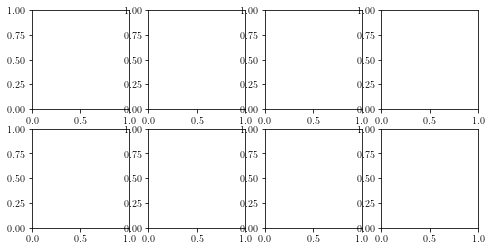

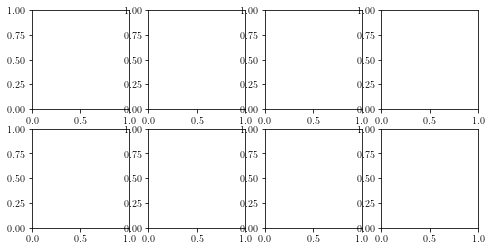

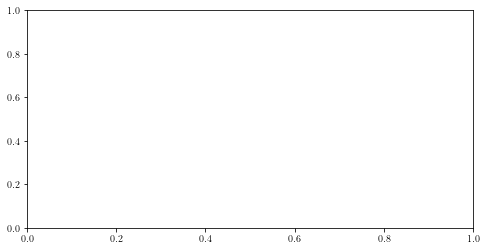

In [24]:

pic = 4

fig, axs = plots(2,4,1,2)
figcheck, axscheck = plots(2,4,1,2)
loss_fig, loss_ax = plots(1,1,2,4)

params = f'mu{mu}lam{lam}'.replace('.','_')
short_list[0][14:-1]
static_dic = np.load(save_path+'static' +short_list[0][24:],allow_pickle=True).item()
true_dic = np.load(save_path+'true'+short_list[0][24:],allow_pickle=True).item()
axs.reshape(-1)[2].set_title('static operator')
axs.reshape(-1)[2].imshow(static_dic.get('X')[pic],cmap = 'Greys_r')
axs.reshape(-1)[1].set_title('precise operator')
axs.reshape(-1)[1].imshow(true_dic.get('X')[pic],cmap = 'Greys_r')
axs.reshape(-1)[0].set_title('original')
axs.reshape(-1)[0].imshow(p,cmap = 'Greys_r')

loss_ax.plot(static_dic.get('loss'),label=r'static operator')
loss_ax.plot(true_dic.get('loss'),label=r'precise operator')

for i,dic_name in enumerate(short_list):
    j= i+3
    m = [r'cor. before ops',
            r'cor.after ops',
        	r'cor in $X$',
            r'cor in $Y$',
            r'sandwich cor.'][i]
    dic = np.load(save_path+dic_name,allow_pickle=True).item()
    axs.reshape(-1)[j].imshow(dic.get('X')[pic],cmap = 'Greys_r')
    axscheck.reshape(-1)[j].set_title(dic_name[8:12])
    axs.reshape(-1)[j].set_title(m)
    # axbig.plot(dic.get('loss'),label=m)
    loss_ax.plot(dic.get('loss'),label=m)

# j
fig.tight_layout()
hide_axis(fig)
fig.set_dpi(200)
loss_ax.legend()
loss_ax.set_yscale('log')
loss_ax.set_ylabel(r'$\|x_i-p\|_X$')
loss_ax.set_xlabel(r'$i$')
loss_fig.tight_layout()
loss_fig.set_dpi(200)

In [298]:

axs.plot((TM-FF),label=r"$\Vert T_{\Theta,\mu}(x_i)\Vert-3 \Vert F_\Theta^\dagger(x_i)-F'(x_i)\Vert$")
axs.plot((TM-1/(c.lam)*(rt_norm*FwL+AdL)),label=r'$\Vert T_{\Theta,\mu}(x_i)\Vert-3(\Vert A\Vert\Vert(A-A_\Theta)(x_i)\Vert + \Vert(A^*-A_\Phi^*)(A_\Theta(x_i)-y)\Vert)$')
axs.plot(LL,label='$\mathcal{L}(x_i)-\mathcal{L}(x_{i+1})$')
axs.plot(AL,label='$H_{\Theta,\mu}(x_i)$')
axs.set_yscale('log')
axs.set_xlabel(r'$i$')
axs.legend()
axs.set_xlim([0,100])
fig.set_dpi(300)


<AxesSubplot:>

In [25]:

rt_norm = np.sqrt(np.linalg.norm((A_static_s.T@A_static_s).todense(),2))

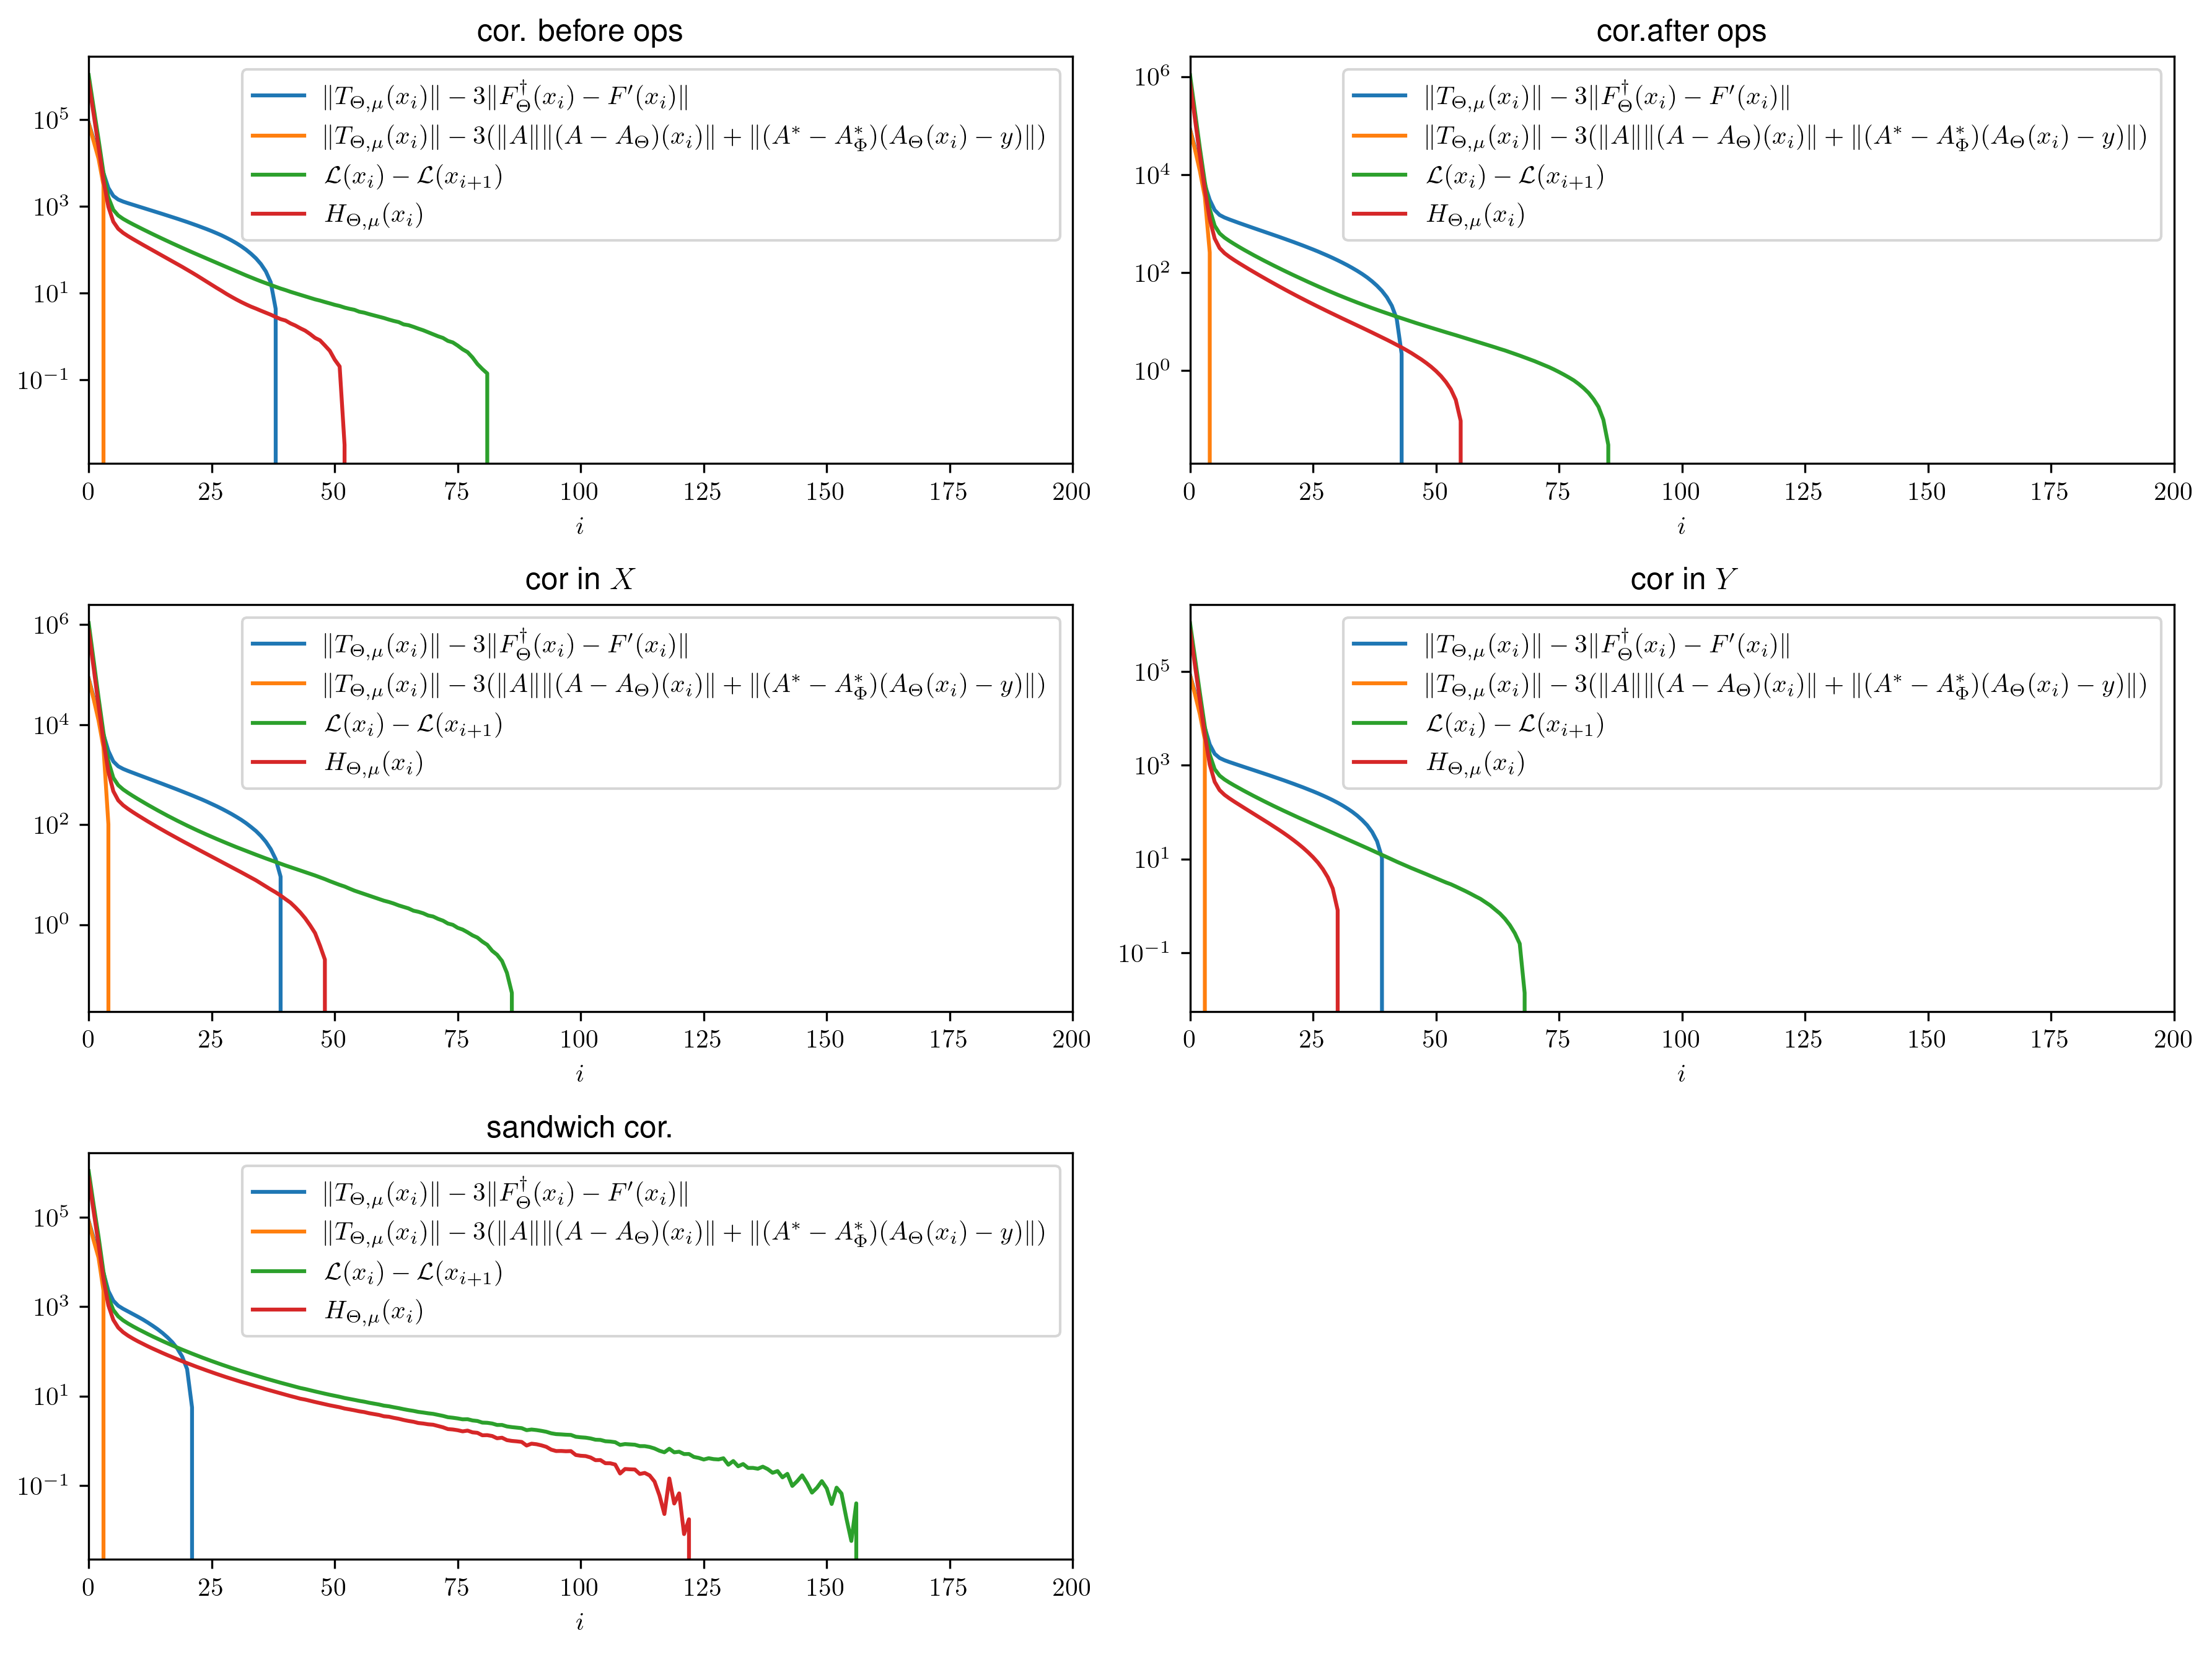

In [43]:

j = 4

fig, axs = plots(3,2,2)

lam = 0.001

for i,dic_name in enumerate(short_list):
    j= i
    m = [r'cor in $X$',r'cor. before ops',r'cor.after ops',r'cor in $Y$',r'sandwich cor.'][i]
    dic = np.load(save_path+dic_name,allow_pickle=True).item()
    # axs.reshape(-1)[j].plot(dic.get('TThetaMu',0),label = 'TTm')
    LL = dic.get('LL')
    AL = dic.get('AL')
    TM = dic.get('TThetaMu')
    FF = dic.get('FF')
    FwL = dic.get('FwL')
    AdL = dic.get('AdL')
    m = [r'cor. before ops',
            r'cor.after ops',
        	r'cor in $X$',
            r'cor in $Y$',
            r'sandwich cor.'][i]
    axs.reshape(-1)[j].set_title(m)
    
    axs.reshape(-1)[j].plot((TM-FF),label=r"$\Vert T_{\Theta,\mu}(x_i)\Vert-3 \Vert F_\Theta^\dagger(x_i)-F'(x_i)\Vert$")
    axs.reshape(-1)[j].plot((TM-1/(lam)*(rt_norm*FwL+AdL)),label=r'$\Vert T_{\Theta,\mu}(x_i)\Vert-3(\Vert A\Vert\Vert(A-A_\Theta)(x_i)\Vert + \Vert(A^*-A_\Phi^*)(A_\Theta(x_i)-y)\Vert)$')
    axs.reshape(-1)[j].plot(LL,label='$\mathcal{L}(x_i)-\mathcal{L}(x_{i+1})$')
    axs.reshape(-1)[j].plot(AL,label='$H_{\Theta,\mu}(x_i)$')
    # axs.reshape(-1)[j].plot(LL/TM**2,label=r'$\Vert T_{\Theta,\mu}\Vert^{-2}(\mathcal{L}(x_i)-\mathcal{L}(x_{i+1}))$')
    # axs.reshape(-1)[j].plot(AL/TM**2,label=r'$\Vert T_{\Theta,\mu}\Vert^{-2}H_{\Theta,\mu}(x_i)$')
    axs.reshape(-1)[j].set_yscale('log')
    axs.reshape(-1)[j].set_xlabel(r'$i$')
    axs.reshape(-1)[j].legend()
    axs.reshape(-1)[j].set_xlim([0,200])
    fig.set_dpi(300)
    fig.tight_layout()

axs.reshape(-1)[5].remove()


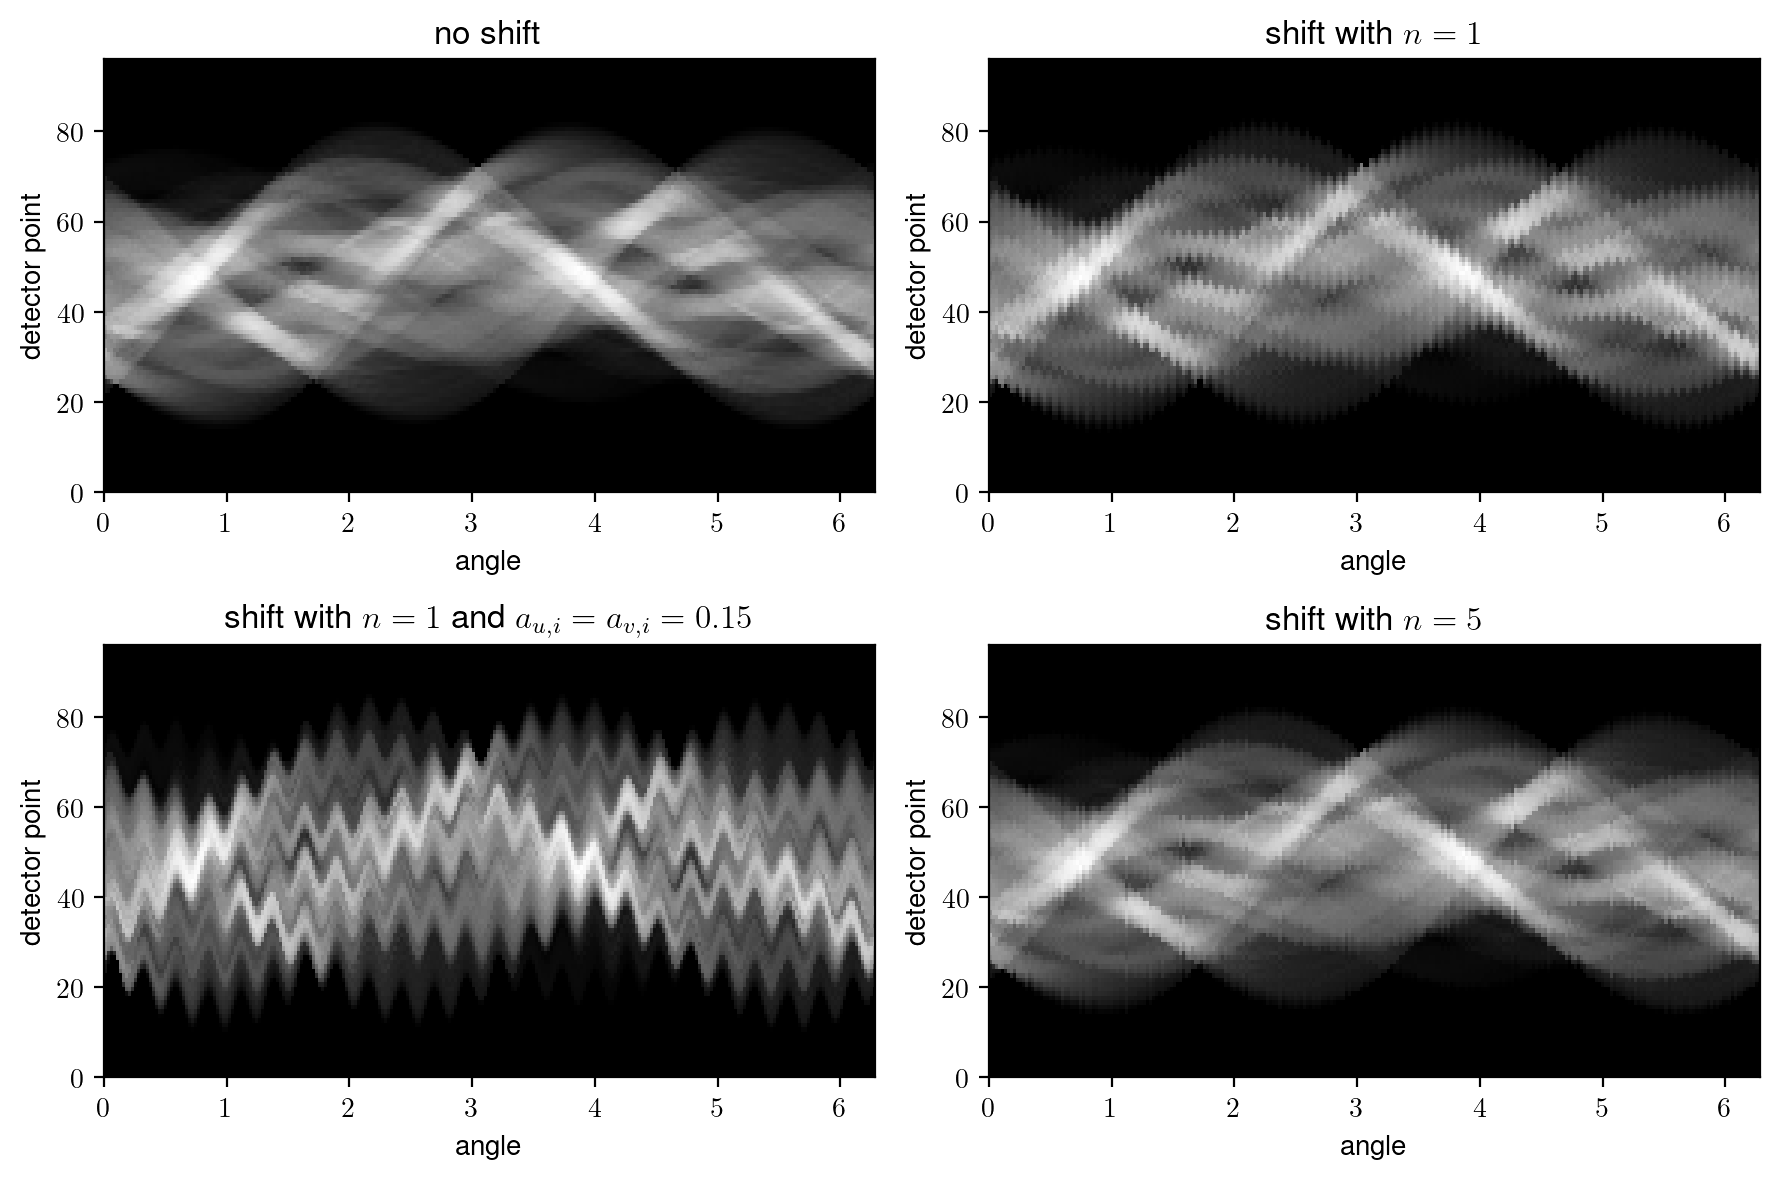

In [287]:
fig, axs = plots(2,2,3/2,3)
axs.reshape(-1)[0].imshow(static_op(p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs.reshape(-1)[0].set_title(r"no shift")
axs.reshape(-1)[0].set_xlabel('angle')
axs.reshape(-1)[0].set_ylabel('detector point')
axs.reshape(-1)[1].imshow(operator_list[1](p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs.reshape(-1)[1].set_title(rf"shift with $n=1$")
axs.reshape(-1)[1].set_xlabel('angle')
axs.reshape(-1)[1].set_ylabel('detector point')
axs.reshape(-1)[2].imshow(operator_list[2](p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs.reshape(-1)[2].set_title(r"shift with $n=1$ and $a_{u,i}=a_{v,i}=0.15$")
axs.reshape(-1)[2].set_xlabel('angle')
axs.reshape(-1)[2].set_ylabel('detector point')
axs.reshape(-1)[3].imshow(operator_list[3](p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs.reshape(-1)[3].set_title(rf"shift with $n=5$")
axs.reshape(-1)[3].set_xlabel('angle')
axs.reshape(-1)[3].set_ylabel('detector point')
fig.tight_layout()
fig.set_dpi(200)